In [123]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, json, requests, pickle
from scipy.stats import skew
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
#import scipy.stats as st
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate #pretty print of tables. source: http://txt.arboreus.com/2013/03/13/pretty-print-tables-in-python.html
from shapely.geometry import Point,Polygon,MultiPoint
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [124]:
#define data set
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-02.csv"
df = pd.read_csv(url)
df.to_csv(url.split('/')[-1])

In [5]:
df.shape[0]

1510722

In [6]:
len(df.columns)

21

## Question 1: Report the number of rows and columns that you've loaded.

In [125]:
df.shape

(1510722, 21)

## Q2:Visualize trip distance by time of day in any way you see fit, any observations?

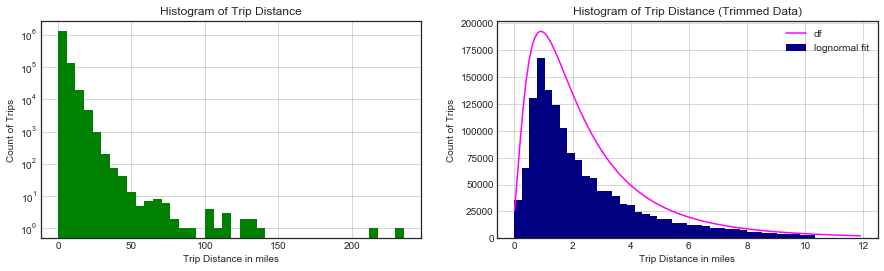

In [129]:
# Trip Distance Graphs Exploration 

fig,ax = plt.subplots(1,2,figsize = (15,4)) 

# Histogram of the number of trip distance
df.Trip_distance.hist(bins=40,ax=ax[0],color = 'green')
ax[0].set_xlabel('Trip Distance in miles')
ax[0].set_ylabel('Count of Trips')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Trip Distance')

# creating a vector to contain Trip Distance
v = df.Trip_distance 

# Excluding any data point located further than 3 standard deviations of the median point and 
# Plotting the histogram with 50 bins
v[~((v-v.median()).abs()>3*v.std())].hist(bins=40,ax=ax[1], color= 'navy') 
ax[1].set_xlabel('Trip Distance in miles')
ax[1].set_ylabel('Count of Trips')
ax[1].set_title('Histogram of Trip Distance (Trimmed Data)')

# Applying a lognormal fit. Use the mean of trip distance as a scale parameter
scatter,loc,mean = lognorm.fit(df.Trip_distance.values,
                               scale=df.Trip_distance.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,.1),scatter,loc,mean)
ax[1].plot(np.arange(0,12,.1),600000*pdf_fitted,'r', color='fuchsia') 
ax[1].legend(['df','lognormal fit'])

# Exporting the figure
plt.savefig('trip_distance.jpeg',format='jpeg')
plt.show()

In [131]:
# #String to Datetime conversion
df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
df["Lpep_dropoff_datetime"] = pd.to_datetime(df["Lpep_dropoff_datetime"])
df["pickup_dayofweek"] = df.lpep_pickup_datetime.dt.dayofweek
df["pickup_weekday_name"] = df.lpep_pickup_datetime.dt.weekday_name
df["pickup_hour"] = df.lpep_pickup_datetime.dt.hour
df["pickup_month"] = df.lpep_pickup_datetime.dt.month

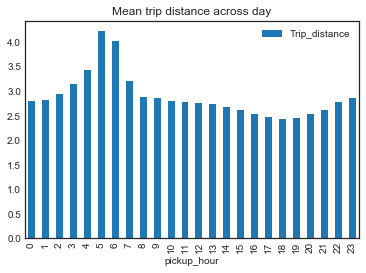

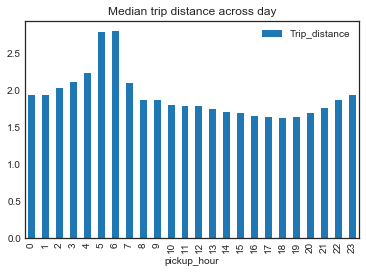

In [132]:
df[['Trip_distance','pickup_hour']].groupby('pickup_hour').mean().plot.bar()
plt.title('Mean trip distance across day')
plt.show()
df[['Trip_distance','pickup_hour']].groupby('pickup_hour').median().plot.bar()
plt.title('Median trip distance across day')
plt.show()

# For Better Visulaization, plot median & mean distance in one graph

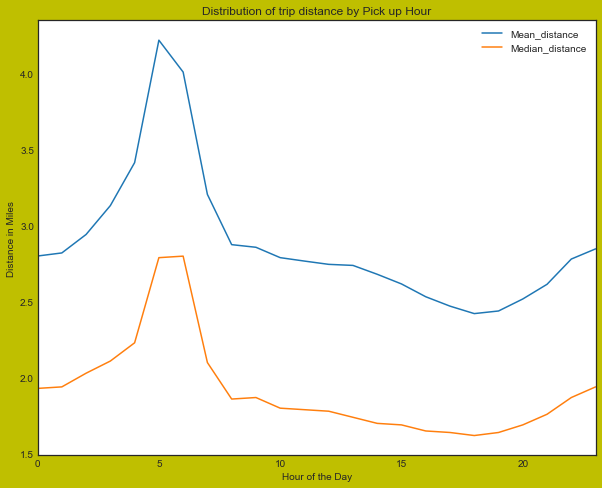

In [143]:

fig,ax = plt.subplots(1,1,figsize=(10,8), facecolor='y') 

table1 = df.pivot_table(index='pickup_hour', values='Trip_distance',aggfunc=('mean','median')).reset_index()
table1.columns = ['Hour of the Day','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Distance in Miles')
plt.xlabel('Hour of the Day')
plt.title('Distribution of trip distance by Pick up Hour')
#plt.xticks(np.arange(0,30,6)+0.35,range(0,30,6))
plt.xlim([0,23])
plt.savefig('Question2_1.jpeg',format='jpeg')
plt.show()

In [20]:

from sklearn import linear_model
import seaborn as sns

import os
import sys
import time
import requests
import datetime

import missingno as msno

# Few Extra Analysis for pickup per Day of Week

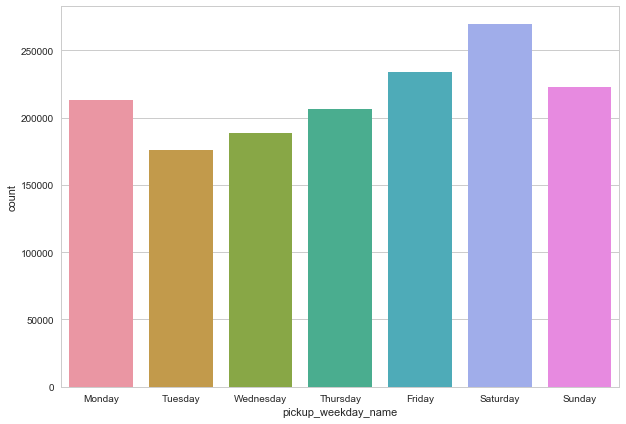

In [154]:
plt.figure(figsize=(10,7))
sns.countplot(x="pickup_weekday_name", data=df)
plt.show()

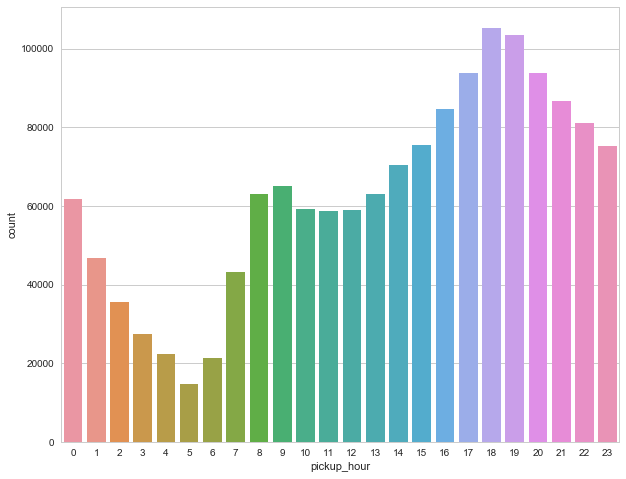

In [155]:
plt.figure(figsize=(1,8))
sns.countplot(x="pickup_hour", data=df)
plt.show()

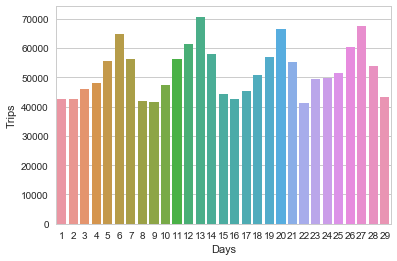

In [157]:
ax = sns.countplot(df.lpep_pickup_datetime.dt.day)
ax.set(xlabel='Days', ylabel='Trips')
plt.show()

In [161]:
# select airport trips
airports_trips = df[(df.RateCodeID==2) | (df.RateCodeID==3)]
print ("Number of trips to/from NYC airports: ", airports_trips.shape[0])
print ("Average fare (calculated by the meter) of trips to/from NYC airports: $", airports_trips.Fare_amount.mean(),"per trip")
print ("Average total charged amount (before tip) of trips to/from NYC airports: $", airports_trips.Total_amount.mean(),"per trip")

Number of trips to/from NYC airports:  4367
Average fare (calculated by the meter) of trips to/from NYC airports: $ 48.057591023585985 per trip
Average total charged amount (before tip) of trips to/from NYC airports: $ 57.41204488206781 per trip


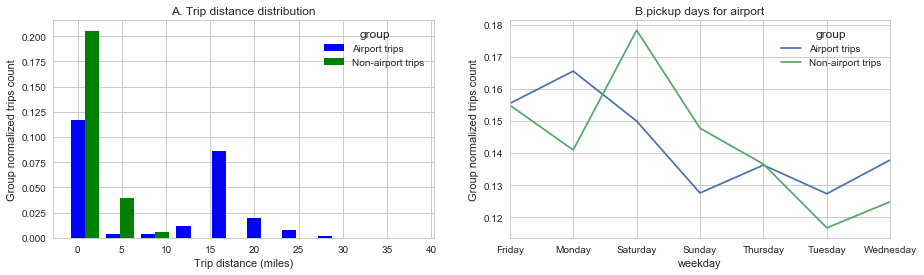

In [179]:
# create a vector to contain Trip Distance for
v2 = airports_trips.Trip_distance # airport trips
v3 = df.loc[~df.index.isin(v2.index),'Trip_distance'] # non-airport trips

# remove outliers: 
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v2 = v2[~((v2-v2.median()).abs()>3*v2.std())]
v3 = v3[~((v3-v3.median()).abs()>3*v3.std())] 

# define bins boundaries
bins = np.histogram(v2,normed=True)[1]
h2 = np.histogram(v2,bins=bins,normed=True)
h3 = np.histogram(v3,bins=bins,normed=True)

# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize = (15,4))
w = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h2[0],alpha=1,width=w,color='b')
ax[0].bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='g')
ax[0].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
ax[0].set_xlabel('Trip distance (miles)')
ax[0].set_ylabel('Group normalized trips count')
ax[0].set_title('A. Trip distance distribution')
#ax[0].set_yscale('log')

# plot hourly distribution
airports_trips.pickup_weekday_name.value_counts(normalize=True).sort_index().plot(ax=ax[1])
df.loc[~df.index.isin(v2.index),'pickup_weekday_name'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('weekday')
ax[1].set_ylabel('Group normalized trips count')
ax[1].set_title('B.pickup days for airport')
ax[1].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
plt.show()


In [206]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [207]:
df['distance'] = haversine_np(df.Pickup_longitude, df.Pickup_latitude,
                                           df.Dropoff_longitude, df.Dropoff_latitude)

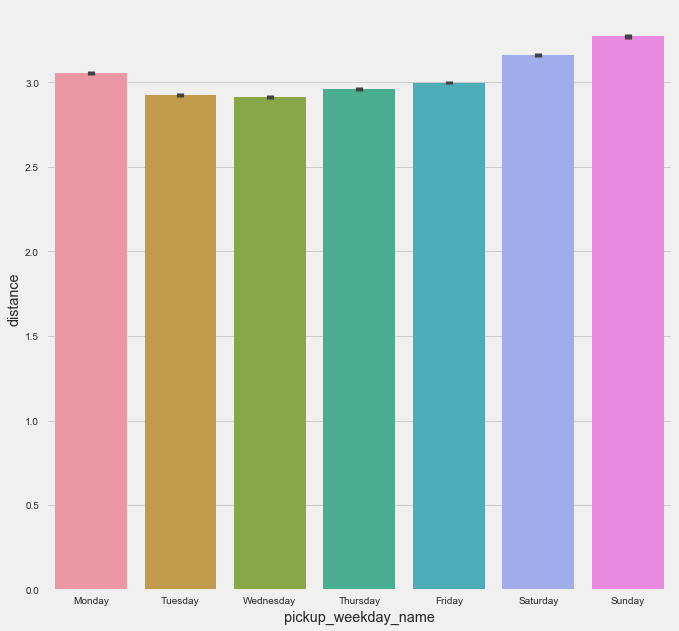

In [211]:
import seaborn as sns
#sns.set(style="ticks")
sel = df[['distance','pickup_weekday_name']]
sns.barplot(x='pickup_weekday_name',y='distance',data=sel)
#sns.despine(offset=7, trim=True)

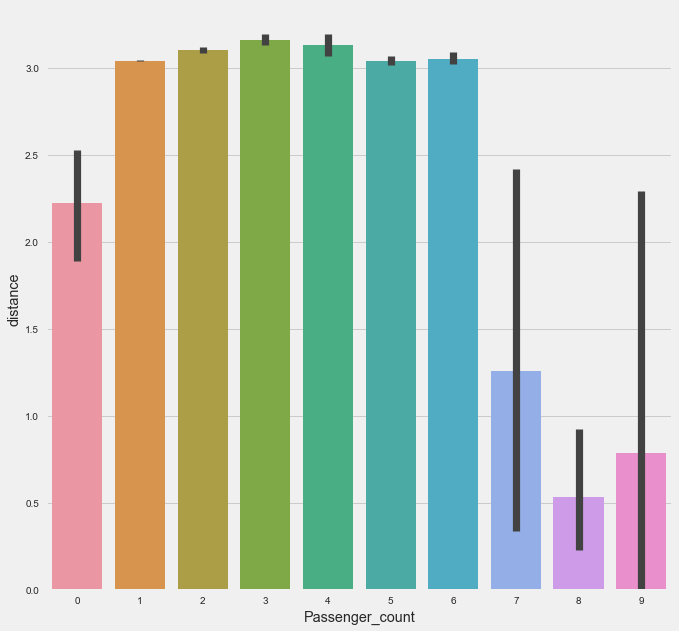

In [208]:

#sns.set(style="ticks")
sel = df[['distance','Passenger_count']]
sns.barplot(x='Passenger_count',y='distance',data=sel)
#sns.despine(offset=10, trim=True)

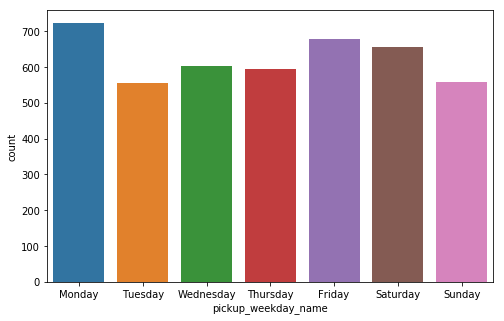

In [46]:
#Airport trips per day
plt.figure(figsize=(8,5))
sns.countplot(x="pickup_weekday_name", data=df[(df.RateCodeID==2) | (df.RateCodeID==3)])
plt.show()

In [110]:
# #trip_duration represents the difference between the dropoff_datetime and the pickup_datetime in the
# #dataset
trip_duration = pd.DataFrame(df["Lpep_dropoff_datetime"] - df["lpep_pickup_datetime"])

In [111]:
trip_duration.describe()

,0
count,1195381
mean,0 days 00:20:17.444431
std,0 days 01:47:34.605907
min,0 days 00:00:00
25%,0 days 00:05:28
50%,0 days 00:09:07
75%,0 days 00:15:14
max,0 days 23:59:57


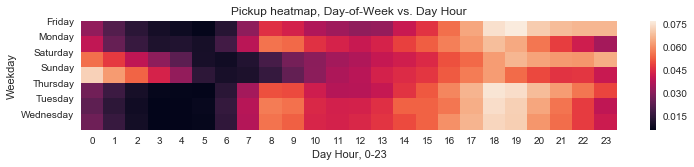

In [184]:
# Pickup heatmap
plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(df.pickup_weekday_name, 
                             df.pickup_hour, 
                             values=df.VendorID, 
                             aggfunc='count',
                             normalize='index'))

plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), rotation='horizontal')
pass

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ROWS_SAMPLE = 80000

# Delete locations far away from the others
longitude_limit = [-74.027, -73.85]
latitude_limit = [40.67, 40.85]
df = df[(df.Pickup_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
df = df[(df.Dropoff_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
df = df[(df.Pickup_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]
df = df[(df.Dropoff_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]

df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
df["Lpep_dropoff_datetime"] = pd.to_datetime(df["Lpep_dropoff_datetime"])

df_trimmed = df.sample(ROWS_SAMPLE)
df_trimmed.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Payment_type,Trip_type,Pickup_dt,Dropoff_dt,Pickup_hour,pickup_dayofweek,pickup_weekday_name,pickup_hour,pickup_month,Tip_percentage
883609,2,2016-02-18 13:46:04,2016-02-18 14:07:50,N,1,-73.902138,40.836834,-73.942116,40.822777,1,...,2,1.0,2016-02-18 13:46:04,2016-02-18 14:07:50,13,3,Thursday,13,2,0.000000
202835,2,2016-02-05 15:12:20,2016-02-05 15:15:47,N,1,-73.965530,40.805889,-73.958252,40.815376,1,...,1,1.0,2016-02-05 15:12:20,2016-02-05 15:15:47,15,4,Friday,15,2,20.000000
38995,1,2016-02-01 21:45:09,2016-02-01 22:00:45,N,1,-73.852043,40.834114,-73.915993,40.813084,1,...,2,1.0,2016-02-01 21:45:09,2016-02-01 22:00:45,21,0,Monday,21,2,0.000000
1196864,2,2016-02-24 10:48:43,2016-02-24 10:58:07,N,1,-73.960564,40.812836,-73.971413,40.787651,1,...,1,1.0,2016-02-24 10:48:43,2016-02-24 10:58:07,10,2,Wednesday,10,2,16.666667
366775,2,2016-02-08 09:49:29,2016-02-08 09:52:16,N,1,-73.966660,40.689644,-73.980988,40.689865,1,...,1,1.0,2016-02-08 09:49:29,2016-02-08 09:52:16,9,0,Monday,9,2,8.620690


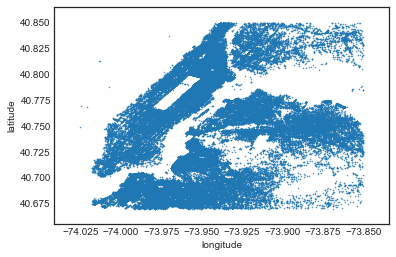

In [103]:
longitude = list(df_trimmed.Pickup_longitude) + list(df_trimmed.Dropoff_longitude)
latitude = list(df_trimmed.Pickup_latitude) + list(df_trimmed.Dropoff_latitude)

data = pd.DataFrame({'latitude': latitude, 'longitude': longitude})
sns.set_style("white")
ax = sns.regplot(x="longitude", y="latitude", data=data, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})
plt.show()

## Q3 What are the most popular pickup locations on weekdays vs weekend?

Most popular pickup locations on weekdends:


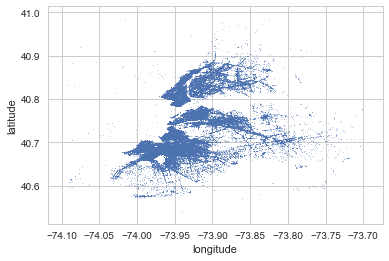

Most popular pickup locations on weekdays:


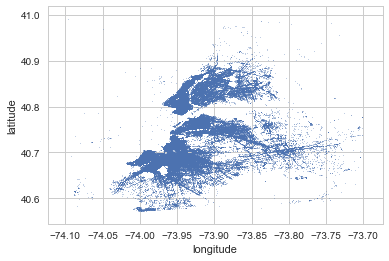

In [175]:

# Delete locations far away from the others and convert to pandas datetime format
longitude_limit = [-74.1, -73.7]
latitude_limit = [40.5, 41]
df = df[(df.Pickup_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
df = df[(df.Dropoff_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
df = df[(df.Pickup_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]
df = df[(df.Dropoff_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]

df["pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["Lpep_dropoff_datetime"])

df['WEEKEND'] = ((pd.DatetimeIndex(df.pickup_datetime).dayofweek) // 5 == 1).astype(float)

longitude_weekend = list(df.Pickup_longitude[df.WEEKEND == 1])
latitude_weekend = list(df.Pickup_latitude[df.WEEKEND == 1])
data_weekend = pd.DataFrame({'latitude': latitude_weekend, 'longitude': longitude_weekend})

longitude_weekday = list(df.Pickup_longitude[df.WEEKEND == 0])
latitude_weekday = list(df.Pickup_latitude[df.WEEKEND == 0])
data_weekday = pd.DataFrame({'latitude': latitude_weekday, 'longitude': longitude_weekday})

print('Most popular pickup locations on weekdends:')
sns.set_style("whitegrid")
ax = sns.regplot(x="longitude", y="latitude", data=data_weekend, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})
plt.show()

print('Most popular pickup locations on weekdays:')
sns.set_style("whitegrid")
ax = sns.regplot(x="longitude", y="latitude", data=data_weekday, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})
plt.show()

In [209]:
from sklearn.cluster import KMeans
import numpy as np
import pickle

try:
    kmeans = pickle.load(open("source_kmeans.pickle", "rb"))
except:
    kmeans = KMeans(n_clusters=20, random_state=0).fit(df[['Pickup_longitude','Pickup_latitude']])
    pickle.dump(kmeans, open('source_kmeans.pickle', 'wb'))

try:
    destkmeans = pickle.load(open("dest_kmeans.pickle", "rb"))
except:
    destkmeans = KMeans(n_clusters=20, random_state=0).fit(df[['Dropoff_longitude','Dropoff_latitude']])
    pickle.dump(destkmeans, open('dest_kmeans.pickle', 'wb'))

In [212]:
cx = [c[0] for c in kmeans.cluster_centers_]
cy = [c[1] for c in kmeans.cluster_centers_]

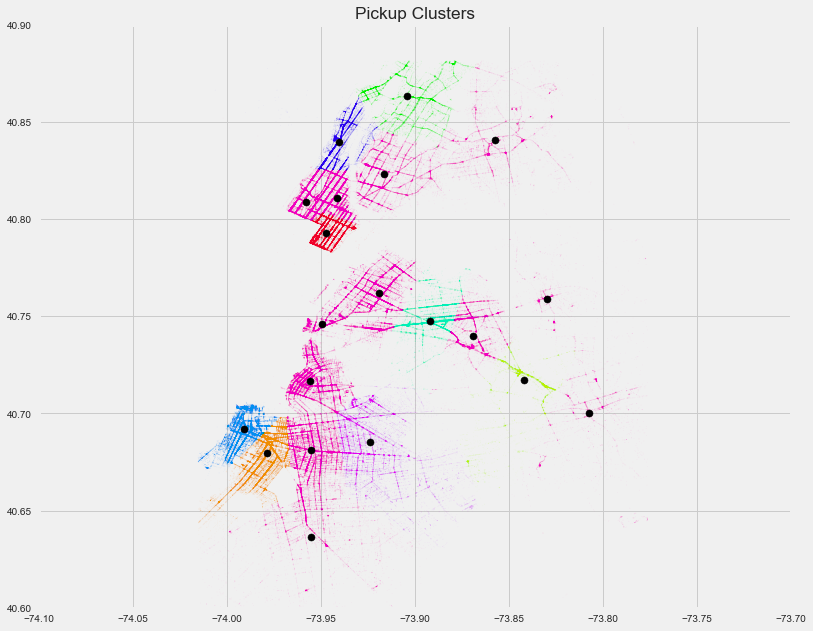

In [214]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)

df['cluster'] = kmeans.predict(df[['Pickup_longitude','Pickup_latitude']])
df['dest_cluster'] = destkmeans.predict(df[['Dropoff_longitude','Dropoff_latitude']])
cm = plt.get_cmap('gist_rainbow')

colors = [cm(2.*i/15) for i in range(20)]
colored = [colors[k] for k in df['cluster']]

#plt.figure(figsize = (10,10))
ax.scatter(df.Pickup_longitude,df.Pickup_latitude,color=colored,s=0.0002,alpha=1)
ax.scatter(cx,cy,color='Black',s=50,alpha=1)
plt.title('Pickup Clusters')
plt.show()
#plt.ylim(40.6, 40.9)

#ax.scatter(sdf['pickup_longitude'],sdf['pickup_latitude'], s=0.1, alpha=1)
#ax.scatter(cx,cy,s=70,color='Red')

In [215]:
#create new column call weekday
timestamp = pd.to_datetime(pd.Series(df['lpep_pickup_datetime']))
df['weekday'] = timestamp.dt.weekday_name
df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,trip_duration,Trip_duration,src lat [km],src long [km],dst lat [km],dst long [km],distance,cluster,dest_cluster,weekday
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,...,10,10,6.493780,0.618339,4.342068,-2.208263,3.544537,11,10,Monday
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,...,19,19,-0.025479,4.626286,-0.332078,4.678404,0.310453,4,16,Monday
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,...,18,18,-7.875598,-3.156684,-3.178521,-0.896303,5.204267,1,18,Monday
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,...,6,6,-5.176934,11.708556,-4.553120,9.672733,2.126802,12,4,Monday
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,...,2,2,-0.216573,3.574915,-1.478214,3.908214,1.302649,4,16,Monday


In [216]:
#get rid off some garbage data
df=df[(df['Pickup_latitude'] > 40.492083) & (df['Pickup_latitude']<40.944536) &
     (df['Pickup_longitude']> -74.267880)& (df['Pickup_longitude']< -73.662022)]

df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,trip_duration,Trip_duration,src lat [km],src long [km],dst lat [km],dst long [km],distance,cluster,dest_cluster,weekday
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,...,10,10,6.493780,0.618339,4.342068,-2.208263,3.544537,11,10,Monday
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,...,19,19,-0.025479,4.626286,-0.332078,4.678404,0.310453,4,16,Monday
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,...,18,18,-7.875598,-3.156684,-3.178521,-0.896303,5.204267,1,18,Monday
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,...,6,6,-5.176934,11.708556,-4.553120,9.672733,2.126802,12,4,Monday
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,...,2,2,-0.216573,3.574915,-1.478214,3.908214,1.302649,4,16,Monday


In [218]:
#get all the selected weekdays in selected month
my_weekday="Monday"
my_montn=2
df_select=df[(df['weekday']==my_weekday) & 
                 (pd.to_datetime(df['lpep_pickup_datetime']) < pd.datetime(2016,my_montn+1,1))&
                (pd.to_datetime(df['lpep_pickup_datetime']) > pd.datetime(2016,my_montn,1))]
df_select=df_select[:70000]
df_select.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,trip_duration,Trip_duration,src lat [km],src long [km],dst lat [km],dst long [km],distance,cluster,dest_cluster,weekday
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,...,10,10,6.493780,0.618339,4.342068,-2.208263,3.544537,11,10,Monday
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,...,19,19,-0.025479,4.626286,-0.332078,4.678404,0.310453,4,16,Monday
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,...,18,18,-7.875598,-3.156684,-3.178521,-0.896303,5.204267,1,18,Monday
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,...,6,6,-5.176934,11.708556,-4.553120,9.672733,2.126802,12,4,Monday
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,...,2,2,-0.216573,3.574915,-1.478214,3.908214,1.302649,4,16,Monday


In [219]:
%%time
#use Kmean to group data by longitude and latitude
my_cluster=100
from sklearn.cluster import KMeans
lon=df_select['Pickup_longitude'].values
lat=df_select['Pickup_latitude'].values
coodinate_array=np.array([[lon[i],lat[i]] for i in range(len(lon))])

kmeans_n = KMeans(n_clusters=my_cluster,  n_init=1, random_state=1000)
kmeans_n.fit(coodinate_array)
labels = kmeans_n.labels_
print(labels)

[38  2  0 ...,  2 37 10]
CPU times: user 5.19 s, sys: 471 ms, total: 5.66 s
Wall time: 1.47 s


In [220]:
# add new column call cluster
df_select['Cluster']=labels
df_select.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Trip_duration,src lat [km],src long [km],dst lat [km],dst long [km],distance,cluster,dest_cluster,weekday,Cluster
0,2,2016-02-01 00:00:01,2016-02-01 00:10:06,N,1,-73.939018,40.805214,-73.972534,40.785885,1,...,10,6.493780,0.618339,4.342068,-2.208263,3.544537,11,10,Monday,38
1,2,2016-02-01 00:01:33,2016-02-01 00:20:13,N,1,-73.891495,40.746651,-73.890877,40.743896,1,...,19,-0.025479,4.626286,-0.332078,4.678404,0.310453,4,16,Monday,2
2,2,2016-02-01 00:03:46,2016-02-01 00:21:04,N,1,-73.983780,40.676132,-73.956978,40.718327,1,...,18,-7.875598,-3.156684,-3.178521,-0.896303,5.204267,1,18,Monday,0
3,2,2016-02-01 00:00:05,2016-02-01 00:06:48,N,1,-73.807518,40.700375,-73.831657,40.705978,1,...,6,-5.176934,11.708556,-4.553120,9.672733,2.126802,12,4,Monday,4
4,2,2016-02-01 00:06:20,2016-02-01 00:08:47,N,1,-73.903961,40.744934,-73.900009,40.733601,5,...,2,-0.216573,3.574915,-1.478214,3.908214,1.302649,4,16,Monday,85


In [222]:
#prepare for regression
Cluster_size=df_select.groupby('Cluster').size()
Cluster_size=np.array([[Cluster_size[i]] for i in range(len(Cluster_size))])
Cluster_center=kmeans_n.cluster_centers_

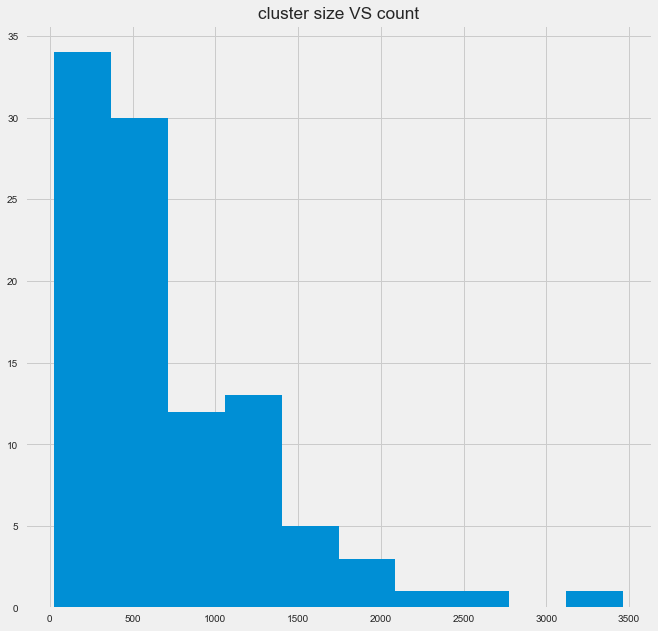

In [223]:
plt.hist(Cluster_size)
plt.title("cluster size VS count")
plt.show()

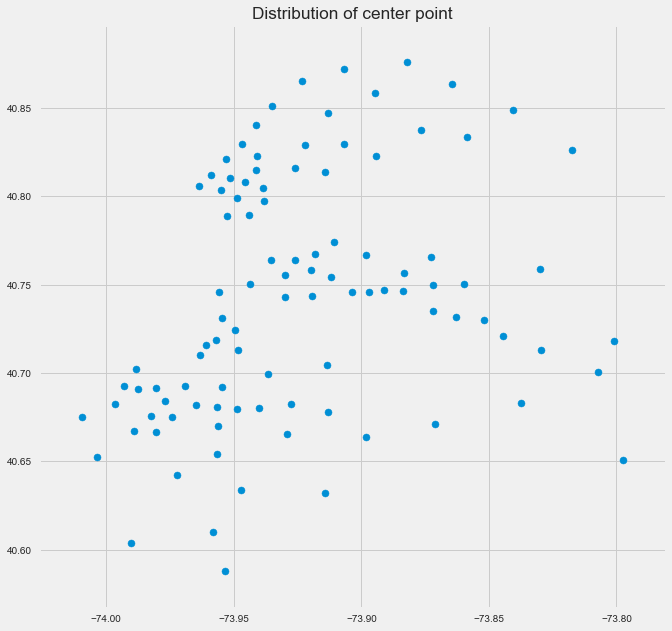

In [224]:
analysis_lon=[]
analysis_lat=[]
for i in range(len(Cluster_center)):
    analysis_lon.append(Cluster_center[i][0])
    analysis_lat.append(Cluster_center[i][1])
plt.scatter(analysis_lon,analysis_lat)
plt.title("Distribution of center point")
plt.show()

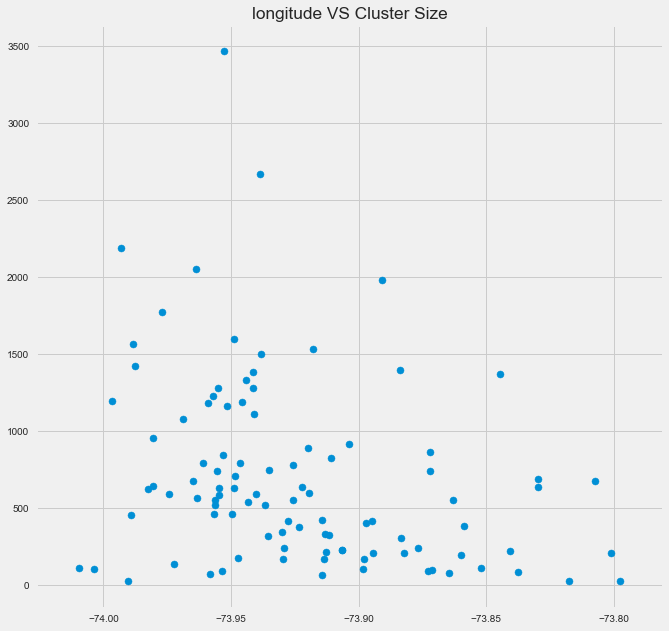

In [225]:
plt.scatter(analysis_lon,Cluster_size)
plt.title("longitude VS Cluster Size")
plt.show()

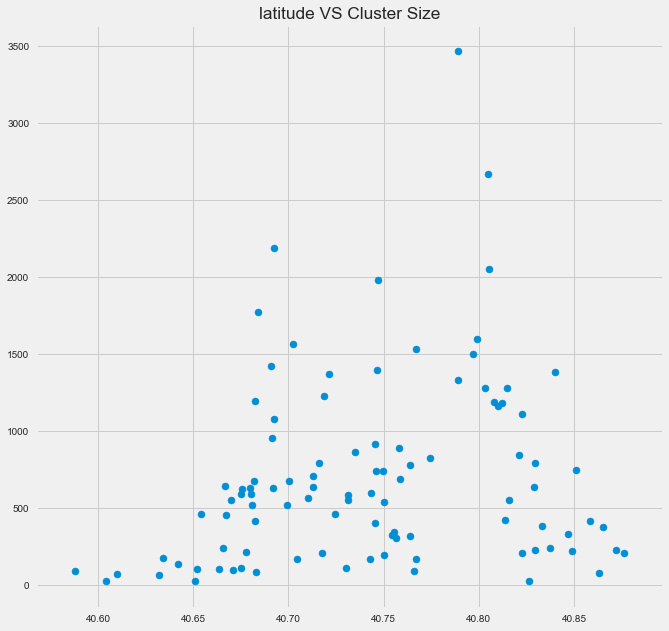

In [226]:
plt.scatter(analysis_lat,Cluster_size)
plt.title("latitude VS Cluster Size")
plt.show()

In [227]:
#use 80% of data for train, use 20% of data for test
train_size=int(len(Cluster_size)*0.8)
test_size=int(len(Cluster_size)*0.2)
train_feature=Cluster_size[:train_size]
train_response=Cluster_center[:train_size]
test_feature=Cluster_size[test_size:]
test_response=Cluster_center[test_size:]

In [228]:
#coefficient of determination (R^2)
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


def fit_model(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score(data, response, validation, val_response):
    model = fit_model(data, response)
    return score_model(model, data, response, validation, val_response)

print (fit_model_and_score(train_feature, train_response,
                           test_feature, test_response))

(0.10042846146340235, 0.084129967521214391)


In [229]:
#use mean squared error to evaluation model
from sklearn.metrics import mean_squared_error

MSE_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
MSE_model.fit(train_feature, train_response)
X_MSE=(test_feature)
y_MSE = MSE_model.predict(X_MSE)
mean_squared_error(test_response, y_MSE)

0.0031094912797552336

In [230]:
#predict best location

X=Cluster_size
y=Cluster_center

prediction_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
prediction_model.fit(X, y)
X_predict=([max(Cluster_size)])
y_predict = prediction_model.predict(X_predict)
y_predict

array([[-73.95368196,  40.80057592]])

In [108]:
# import library
from shapely.geometry import Point,Polygon,MultiPoint
# data points that define the bounding box of the Upper Manhattan
umanhattan = [(40.796937, -73.949503),(40.787945, -73.955822),(40.782772, -73.943575),
              (40.794715, -73.929801),(40.811261, -73.934153),(40.835371, -73.934515),
              (40.868910, -73.911145),(40.872719, -73.910765),(40.878252, -73.926350),
              (40.850557, -73.947262),(40.836225, -73.949899),(40.806050, -73.971255)]

poi = Polygon(umanhattan)
# create a function to check if a location is located inside Upper Manhattan
def is_within_bbox(loc,poi=poi):
    """
    This function returns 1 if a location loc(lat,lon) is located inside a polygon of interest poi
    loc: tuple, (latitude, longitude)
    poi: shapely.geometry.Polygon, polygon of interest
    """
    return 1*(Point(loc).within(poi))
tic = dt.datetime.now()
# Create a new variable to check if a trip originated in Upper Manhattan
df['U_manhattan'] = df[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox((r[0],r[1])),axis=1)
print ("Processing time ", dt.datetime.now()-tic)

Processing time  0:01:11.369230


In [231]:
#prepare for visualization
max_size_cluster=0


for data in y_predict:
    visual_x=data[[0]]
    visual_y=data[[1]]
    
for i in range(len(Cluster_size)):
    if (Cluster_size[i]==Cluster_size.max()):
        max_size_cluster=i
        
actual_value=kmeans_n.cluster_centers_[max_size_cluster]
actual_x=actual_value[0]
actual_y=actual_value[1]

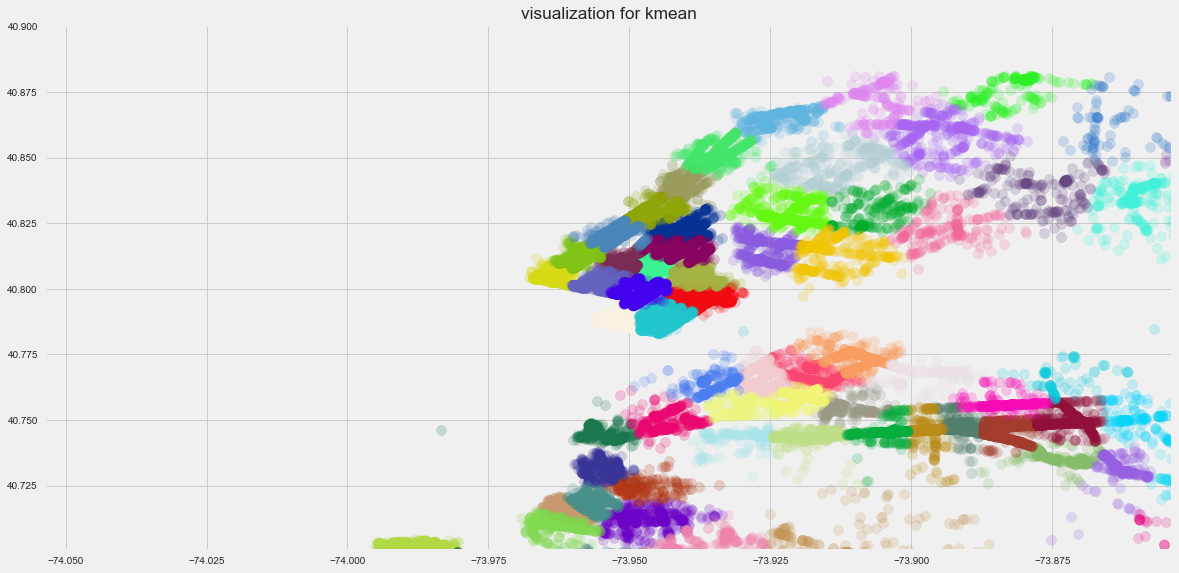

In [232]:
#visualization for kmean cluster
from random import randint
colors = []

for i in range(my_cluster):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

plt.figure(figsize=(18,9))
for i in range(my_cluster):
    my_cluster_df=df_select[df_select['Cluster']==i]
    lon_x=my_cluster_df.Pickup_longitude.values
    lat_y=my_cluster_df.Pickup_latitude.values
    plt.scatter(lon_x,lat_y,alpha=0.2,s=100,c=colors[i])

plt.axis([visual_x-0.1,visual_x+0.1,visual_y-0.1,visual_y+0.1])
plt.title("visualization for kmean")
plt.show()

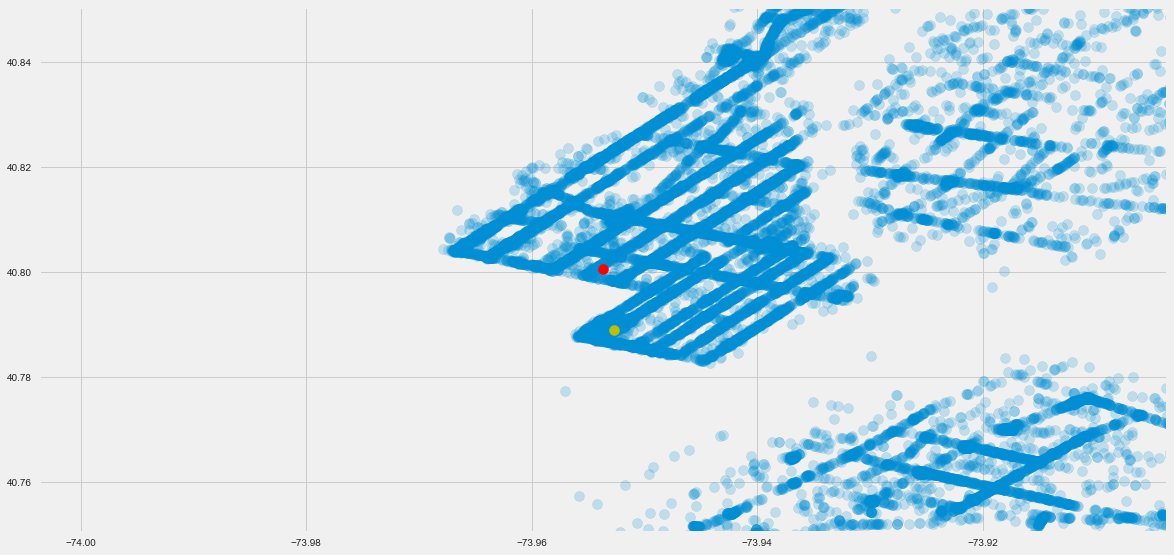

In [233]:
#scatter plot all the data for selected weekday and prediction(best location in red)
x_points=lon
y_points=lat
plt.figure(figsize=(18,9))
plt.scatter(lon,lat,alpha=0.2,s=100)
plt.scatter(visual_x,visual_y ,c='r',s=100)
plt.scatter(actual_x,actual_y ,c='y',s=100)
plt.axis([visual_x-0.05,visual_x+0.05,visual_y-0.05,visual_y+0.05])
plt.show()

 ## 4. I want to know where I can most easily get a cab. Recommend a pick up spot where i can find a cab given my lat long. 

In [236]:
from math import sin, cos, sqrt, atan2, radians

In [237]:


#                       4. NEAREST PICKUP LOCATION:
aux1 = 0
aux2 = 0
distance_lat = 0
distance_long = 0

# approximate radius of earth in km
R = 6373.0

longitude = list(df.Pickup_longitude)
latitude = list(df.Pickup_latitude)
distance = list(df.Pickup_longitude)


longitude_self = float(input("Enter your longitude: "))
latitude_self = float(input("Enter your latitude: "))

# Calculating distances based on the Haversine formula:
for i in range(0, len(longitude)):
#    longitude_radians[i] = radians(longitude_radians[i])
#    latitude_radians[i] = radians(latitude_radians[i])
    distance_lat = radians(abs(latitude_self)) - radians(abs(latitude[i]))
    distance_long = radians(abs(longitude_self)) - radians(abs(longitude[i]))
    aux1 = sin(distance_lat / 2)**2 + cos(latitude[i]) * cos(latitude_self) * sin(distance_long / 2)**2
    aux2 = 2 * atan2(sqrt(aux1), sqrt(1 - aux1))
    distance[i] = R * aux2

data = pd.DataFrame({'latitude': latitude, 'longitude': longitude, 'distance_km': distance})

longitude_go = list(data.longitude[data.distance_km == data.distance_km.min()])
latitude_go = list(data.latitude[data.distance_km == data.distance_km.min()])

print("You should go to latitude: ", latitude_go[0])
print("You should go to longitude: ", longitude_go[0])
print("You are ", data.distance_km.min(), " km away")

Enter your longitude: 73
Enter your latitude: 49
You should go to latitude:  40.8799171448
You should go to longitude:  -73.9730300903
You are  901.239144061  km away


In [192]:
df["dropoff_minute"] = df.Lpep_dropoff_datetime.dt.minute
df["pickup_minute"] = df.lpep_pickup_datetime.dt.minute

df["Trip_duration"] = df["dropoff_minute"] - df["pickup_minute"]

In [120]:
df["trip_duration"].describe()

count    1.195381e+06
mean    -7.045536e-02
std      2.205903e+01
min     -5.900000e+01
25%      3.000000e+00
50%      6.000000e+00
75%      1.200000e+01
max      5.900000e+01
Name: trip_duration, dtype: float64